### 6.2 Keras로 MF 구현하기


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [2]:
import os
base_src = '../data'
u_data_src = os.path.join(base_src, 'u.data')
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(u_data_src,
                    sep = "\t",
                    names = r_cols,
                    encoding = 'latin-1')

ratings_train, ratings_test = train_test_split(ratings,
                                               test_size = 0.2,
                                               shuffle=True,
                                               random_state=2023)

In [3]:
K = 200
mu = ratings_train.rating.mean()

M = ratings.user_id.max() + 1 # 이후 bias term이 들어갈 자리 추가
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [4]:
user = Input(shape = (1,))
item = Input(shape = (1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

Metal device set to: Apple M1


2023-04-03 21:11:38.842406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-03 21:11:38.842546: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
R = layers.dot([P_embedding, Q_embedding], axes = (2,2))
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R)

model = Model(inputs=[user, item], outputs = R)

model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics = [RMSE]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                                              

In [6]:
result = model.fit(
    x = [ratings_train.user_id.values,
         ratings_train.movie_id.values],
    y = ratings_train.rating.values - mu,

    epochs = 60,
    batch_size = 256,
    validation_data = (
        [ratings_test.user_id.values,
         ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/60


2023-04-03 21:11:39.753647: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 21:11:40.124097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - ETA: 0s - loss: 5.2652 - RMSE: 1.1265

2023-04-03 21:11:43.794436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 5s 13ms/step - loss: 5.2652 - RMSE: 1.1265 - val_loss: 4.9978 - val_RMSE: 1.1137
Epoch 2/60
313/313 [==============================] - 4s 11ms/step - loss: 4.7760 - RMSE: 1.1245 - val_loss: 4.5389 - val_RMSE: 1.1118
Epoch 3/60
313/313 [==============================] - 4s 11ms/step - loss: 4.3445 - RMSE: 1.1224 - val_loss: 4.1341 - val_RMSE: 1.1100
Epoch 4/60
313/313 [==============================] - 3s 11ms/step - loss: 3.9639 - RMSE: 1.1207 - val_loss: 3.7769 - val_RMSE: 1.1084
Epoch 5/60
313/313 [==============================] - 4s 12ms/step - loss: 3.6280 - RMSE: 1.1191 - val_loss: 3.4618 - val_RMSE: 1.1069
Epoch 6/60
313/313 [==============================] - 5s 15ms/step - loss: 3.3315 - RMSE: 1.1172 - val_loss: 3.1838 - val_RMSE: 1.1055
Epoch 7/60
313/313 [==============================] - 5s 17ms/step - loss: 3.0702 - RMSE: 1.1161 - val_loss: 2.9386 - val_RMSE: 1.1042
Epoch 8/60
313/313 [==============================] - 4s 13ms/step

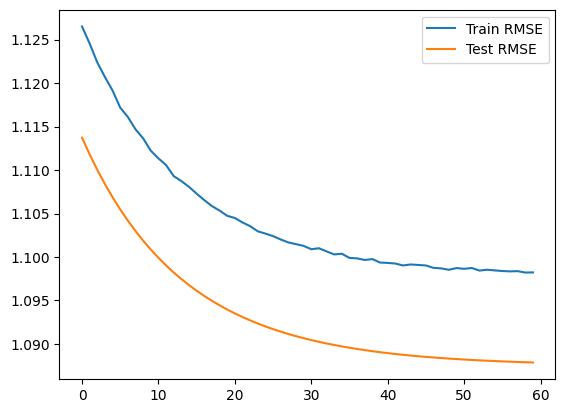

In [7]:
# plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = "Train RMSE")
plt.plot(result.history['val_RMSE'], label = "Test RMSE")
plt.legend()
plt.show()

In [8]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

1/1 [==============================] - 0s 135ms/step


2023-04-03 21:15:38.003824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [9]:
print(ratings_test[0:6])

       user_id  movie_id  rating  timestamp
65740      256       986       5  882164059
11139      326       204       3  879874964
99196      910       205       4  880822060
33120      330       105       4  876545150
41199      378      1145       3  880334409
94043      892      1269       5  886607958


In [10]:
print(predictions)

[[3.5591903]
 [3.5645106]
 [3.5498328]
 [3.5571373]
 [3.5137947]
 [3.5756123]]


In [11]:
import numpy as np

def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [12]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order = 'C')
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

625/625 [==============================] - 2s 3ms/step


1.088895636021346

### 6.3 딥러닝을 활용한 추천시스템

In [4]:
from tensorflow.keras.layers import Dense, Concatenate, Activation

In [5]:
user = Input(shape = (1,))
item = Input(shape = (1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

R = Dense(2048)(R)
R = Activation('linear')(R)

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R)

model = Model(inputs=[user, item], outputs = R)

model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics=[RMSE]
)

model.summary()

2023-04-03 21:40:08.965717: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-03 21:40:08.965835: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_2[0][0]']                
                                                                

In [6]:
# model fitting
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

result = model.fit(
    x = [train_user_ids, train_movie_ids],
    y = train_ratings - mu,
    epochs = 65,
    batch_size = 512,
    validation_data = (
        [test_user_ids, test_movie_ids],
        test_ratings - mu
    )
)

Epoch 1/65


2023-04-03 21:40:09.261854: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-03 21:40:09.692994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 5.3956 - RMSE: 1.1285

2023-04-03 21:40:12.976521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 4s 22ms/step - loss: 5.3956 - RMSE: 1.1285 - val_loss: 5.2486 - val_RMSE: 1.1150
Epoch 2/65
157/157 [==============================] - 3s 22ms/step - loss: 5.1338 - RMSE: 1.1271 - val_loss: 4.9953 - val_RMSE: 1.1131
Epoch 3/65
157/157 [==============================] - 3s 21ms/step - loss: 4.8881 - RMSE: 1.1249 - val_loss: 4.7574 - val_RMSE: 1.1114
Epoch 4/65
157/157 [==============================] - 3s 20ms/step - loss: 4.6574 - RMSE: 1.1230 - val_loss: 4.5340 - val_RMSE: 1.1098
Epoch 5/65
157/157 [==============================] - 3s 18ms/step - loss: 4.4407 - RMSE: 1.1214 - val_loss: 4.3241 - val_RMSE: 1.1081
Epoch 6/65
157/157 [==============================] - 3s 18ms/step - loss: 4.2370 - RMSE: 1.1197 - val_loss: 4.1271 - val_RMSE: 1.1066
Epoch 7/65
157/157 [==============================] - 3s 17ms/step - loss: 4.0457 - RMSE: 1.1176 - val_loss: 3.9415 - val_RMSE: 1.1046
Epoch 8/65
157/157 [==============================] - 3s 18ms/step

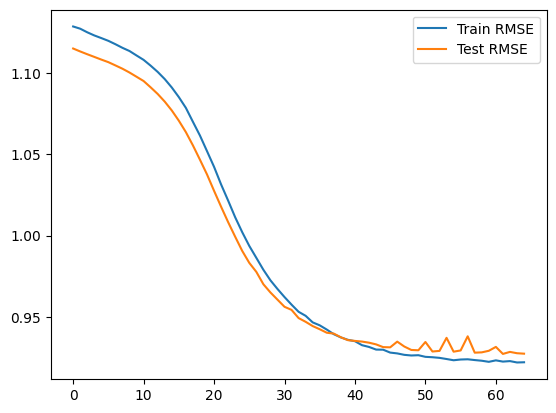

In [7]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = "Train RMSE")
plt.plot(result.history['val_RMSE'], label = "Test RMSE")
plt.legend()
plt.show()

### 6.4 딥러닝 모델에 변수 추가하기

In [17]:
# 사용자 데이터 가져오기
u_user_src = os.path.join(base_src, 'u.user')
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(u_user_src,
                    sep = "|",
                    names = u_cols,
                    encoding = 'latin-1')

# 사용자 ID와 직업(occupation)만 남기기
users = users[['user_id', 'occupation']]

# 직업에 index를 붙여주는 코드
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]

users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)

train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']

In [9]:
train_occ

0        16
1        16
2        16
3        16
4        16
         ..
19995    17
19996    15
19997    15
19998    11
19999    11
Name: occupation, Length: 20000, dtype: int64

In [18]:
K = 200
mu = ratings_train.rating.mean()

N = ratings.user_id.max() + 1
M = ratings.movie_id.max() + 1

user = Input(shape = (1,))
item = Input(shape = (1,))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

user_bias = Embedding(M,1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1, embeddings_regularizer=l2())(item)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

occ = Input(shape=(1,))
OCC_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)
OCC_layer = Flatten()(OCC_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, OCC_layer])

R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item, occ], outputs=R)

model.compile(
    loss = RMSE,
    optimizer = SGD(),
    metrics=[RMSE]
)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 1, 200)       336600      ['input_16[0][0]']               
                                                                                            

In [19]:
# model fitting
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values
train_occs = train_occ.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values
test_occs = test_occ.values

result = model.fit(
    x = [train_user_ids, train_movie_ids, train_occs],
    y = train_ratings - mu,
    epochs = 65,
    batch_size = 512,
    validation_data = (
        [test_user_ids, test_movie_ids, test_occs],
        test_ratings - mu
    )
)

Epoch 1/65


2023-04-03 22:03:47.681526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - ETA: 0s - loss: 5.3928 - RMSE: 1.1278

2023-04-03 22:03:51.250446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


157/157 [==============================] - 5s 24ms/step - loss: 5.3928 - RMSE: 1.1278 - val_loss: 5.2464 - val_RMSE: 1.1144
Epoch 2/65
157/157 [==============================] - 4s 23ms/step - loss: 5.1313 - RMSE: 1.1255 - val_loss: 4.9932 - val_RMSE: 1.1126
Epoch 3/65
157/157 [==============================] - 4s 23ms/step - loss: 4.8858 - RMSE: 1.1240 - val_loss: 4.7555 - val_RMSE: 1.1110
Epoch 4/65
157/157 [==============================] - 4s 22ms/step - loss: 4.6552 - RMSE: 1.1220 - val_loss: 4.5322 - val_RMSE: 1.1093
Epoch 5/65
157/157 [==============================] - 4s 24ms/step - loss: 4.4385 - RMSE: 1.1206 - val_loss: 4.3224 - val_RMSE: 1.1076
Epoch 6/65
157/157 [==============================] - 4s 23ms/step - loss: 4.2349 - RMSE: 1.1185 - val_loss: 4.1253 - val_RMSE: 1.1060
Epoch 7/65
157/157 [==============================] - 3s 19ms/step - loss: 4.0436 - RMSE: 1.1168 - val_loss: 3.9398 - val_RMSE: 1.1039
Epoch 8/65
157/157 [==============================] - 3s 19ms/step

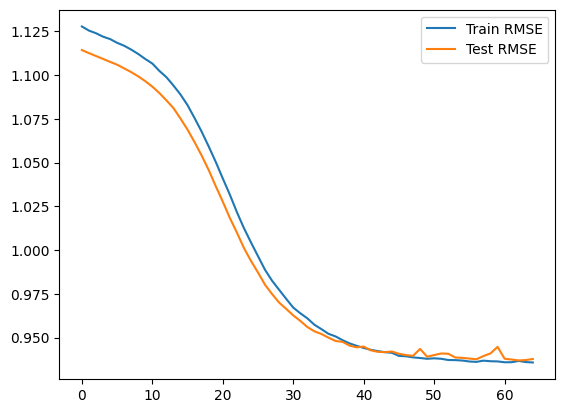

In [20]:
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label = "Train RMSE")
plt.plot(result.history['val_RMSE'], label = "Test RMSE")
plt.legend()
plt.show()